In [185]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix, \
    ConfusionMatrixDisplay, roc_curve
# from lifelines import KaplanMeierFitter

import datetime

# Manually add UTC if it's missing from datetime
if not hasattr(datetime, 'UTC'):
    datetime.UTC = datetime.timezone.utc

# Now import lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [180]:
# Read in files I processed from R
data_clinical = pd.read_parquet("UROMOL_clinical.parquet")
data_rna = pd.read_parquet("UROMOL_rnaseq.parquet")
validate_data_clinical = pd.read_parquet("knowles_clinical.parquet")
validate_data_microarray = pd.read_parquet("knowles_microarray.parquet")

# Take a look at one of the file to make sure we read the correct file
data_clinical.head()


,UROMOL.ID,Progression,PFS_time.,Recurrence,RFS_time,FUtime_days.,Age,Sex,Smoking,Tumor.stage,Tumor.grade,Concomitant.CIS,Tumor.size,Incident.tumor,EAU.risk,BCG,UROMOL2021.classification
0,U0001,0.0,82.40,1.0,32.73,2472,86.0,M,Never,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 1
1,U0002,0.0,72.10,1.0,4.97,2163,73.0,M,Former,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 2b
2,U0007,0.0,62.20,1.0,12.83,1866,66.0,M,Current,Ta,Low grade,Yes,< 3 cm,No,High,1,Class 1
3,U0010,0.0,40.63,1.0,4.33,1219,76.0,M,Current,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 2b
4,U0012,0.0,62.00,0.0,62.00,1860,83.0,F,Never,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 2a


In [95]:
# Data checking and cleaning
# Extract the consensus clinical information 
common_col = list(set(data_clinical.columns) & set(validate_data_clinical.columns))
print(common_col)
# Use the necessary columns for the model (exclude the columns with only one value, e.g. Tumor.stage and Tumor.grade)
clinical_feature = ['BCG', 'Concomitant.CIS', 'UROMOL2021.classification', 'Age', 'Sex', 'Recurrence']

# Label transformation from category to number
mapping_dict = {"No": 0,
                "Yes": 1}
data_clinical["Concomitant.CIS"] = [mapping_dict[x] for x in data_clinical["Concomitant.CIS"].values]
validate_data_clinical["Concomitant.CIS"] = [mapping_dict[x] for x in validate_data_clinical["Concomitant.CIS"].values]

mapping_dict = {"Class 1": 0,
                "Class 2a": 1,
                "Class 2b": 2,
                "Class 3": 3}
data_clinical["UROMOL2021.classification"] = [mapping_dict[x] for x in
                                              data_clinical["UROMOL2021.classification"].values]
mapping_dict = {"Class_1": 0,
                "Class_2a": 1,
                "Class_2b": 2,
                "Class_3": 3}
validate_data_clinical["UROMOL2021.classification"] = [mapping_dict[x] for x in
                                                       validate_data_clinical["UROMOL2021.classification"].values]

mapping_dict = {"F": 0,
                "M": 1}
data_clinical["Sex"] = [mapping_dict[x] for x in data_clinical["Sex"].values]
validate_data_clinical["Sex"] = [mapping_dict[x] for x in validate_data_clinical["Sex"].values]

data_clinical = data_clinical[clinical_feature]
validate_data_clinical = validate_data_clinical[clinical_feature]

# Clinical data, remove the rows without Recurrence
data_clinical = data_clinical.dropna(subset=["Recurrence"])
idx = list(data_clinical.index)
data_rna = data_rna.iloc[idx, :]
data_rna = data_rna.reset_index(drop=True)
data_clinical = data_clinical.reset_index(drop=True)

validate_data_clinical = validate_data_clinical.dropna(subset=["Recurrence"])
idx = list(validate_data_clinical.index)
validate_data_microarray = validate_data_microarray.iloc[idx, :]
validate_data_microarray = validate_data_microarray.reset_index(drop=True)
validate_data_clinical = validate_data_clinical.reset_index(drop=True)


['BCG', 'Tumor.stage', 'Progression', 'Concomitant.CIS', 'FUtime_days.', 'UROMOL2021.classification', 'Recurrence', 'PFS_time.', 'RFS_time', 'Age', 'Tumor.grade', 'Sex']


In [96]:
# RNA-Seq and MicroArray data (already done with normalization or not)
print(f"Max: {max([max(data_rna.iloc[x, :]) for x in range(data_rna.shape[0])])}")
print(f"Min: {min([min(data_rna.iloc[x, :]) for x in range(data_rna.shape[0])])}")

gene_means = data_rna.mean(axis=0)
gene_stds = data_rna.std(axis=0)
print(f"Means: {gene_means.mean():.4f}")
print(f"STDs:  {gene_stds.mean():.4f}")

# --> Normalization was done already!


Max: 23.56512611
Min: -3.741142895
Means: 0.2241
STDs:  1.0134


In [97]:
# Merge the clinical and RNA-Seq data together and split into training set and testing set
df_1 = pd.concat([data_rna, data_clinical], axis=1)

X = df_1.drop("Recurrence", axis=1)
y = df_1["Recurrence"]
# 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 220, Testing samples: 56


In [100]:
# Run Differential Gene Expression for RNA-Seq training set only
group_1 = X_train[y_train == 0]
group_2 = X_train[y_train == 1]

# List of gene columns only
genes = X_train.columns[:-5]
# Calculate p-values for each gene
p_values = {}
for gene in genes:
    t_stat, p_val = ttest_ind(group_1[gene], group_2[gene], nan_policy='omit')
    p_values[gene] = p_val

selected_genes = pd.Series(p_values).sort_values().head(500).index.tolist()


C:\Users\tttin\PycharmProjects\anaconda\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [103]:
# Decide how many genes to select based on the p-values (manually)
pd.Series(p_values).sort_values()

LncRNA2747_ENSG00000256494    1.328503e-14
REXO1L9P                      1.328503e-14
RN7SL718P                     1.328503e-14
TSPY6P                        1.328503e-14
SCUBE3                        1.178233e-06
                                  ...     
OR6K2                         9.999432e-01
ZNF337                        9.999502e-01
PON3                          9.999580e-01
OTOP2                         9.999616e-01
SSBP2                         9.999791e-01
Length: 33197, dtype: float64

In [104]:
# Keep the genes only if it is also in microarray data
top_genes = [x for x in selected_genes if x in validate_data_microarray.columns][:25]

final_col = top_genes + list(X_train.columns[-5:])
X_train_final = X_train[final_col]
X_test_final = X_test[final_col]

In [105]:
# Check the top genes
top_genes

['SCUBE3',
 'SNX7',
 'ARHGEF25',
 'RNF141',
 'DSC2',
 'TM7SF3',
 'GLIS2',
 'ZNF816',
 'UGP2',
 'DERA',
 'LDB3',
 'ADAM9',
 'MED21',
 'MYL9',
 'EGR3',
 'TAF4',
 'RAB21',
 'KIF21B',
 'HHIPL1',
 'ATP11B',
 'CRYZ',
 'EML4',
 'ZBTB6',
 'RAB33B',
 'AATK']

In [106]:
X_train_final.head()

,SCUBE3,SNX7,ARHGEF25,RNF141,DSC2,TM7SF3,GLIS2,ZNF816,UGP2,DERA,...,CRYZ,EML4,ZBTB6,RAB33B,AATK,BCG,Concomitant.CIS,UROMOL2021.classification,Age,Sex
258,0.505229,4.184407,2.398835,5.323846,4.035035,5.491317,-1.206449,4.354778,5.805269,4.274030,...,4.345744,7.641676,2.374103,4.058122,-0.042219,0,0,3,44.0,1
232,1.532940,5.082172,-0.061942,5.815572,5.413626,5.486368,1.627304,5.217583,6.123432,3.997146,...,5.943177,6.955467,3.972684,3.662908,-0.475699,1,0,1,NaN,1
33,1.741981,4.456051,0.220127,6.823014,3.844062,6.261941,0.678845,5.997275,7.065371,4.417323,...,6.690228,8.419640,4.498413,3.999058,-0.969157,0,0,0,67.0,1
157,-1.296688,4.681453,0.065960,5.531731,1.731034,5.716290,-3.741143,5.271233,6.166846,4.274024,...,5.688674,7.585943,2.675372,2.022226,0.795904,1,1,3,58.0,0
148,1.514404,4.872141,0.852102,5.837222,2.735781,6.337522,0.948202,5.028907,6.180373,4.488444,...,6.425758,7.370594,3.931683,4.575186,-0.611818,1,0,2,59.0,1


In [107]:
# Start training the classifier by Random Forest
classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')

# Fit the model
classifier.fit(X_train_final, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [108]:
# Predict the testing data
y_pred_rna = classifier.predict(X_test_final)

<Figure size 600x500 with 0 Axes>

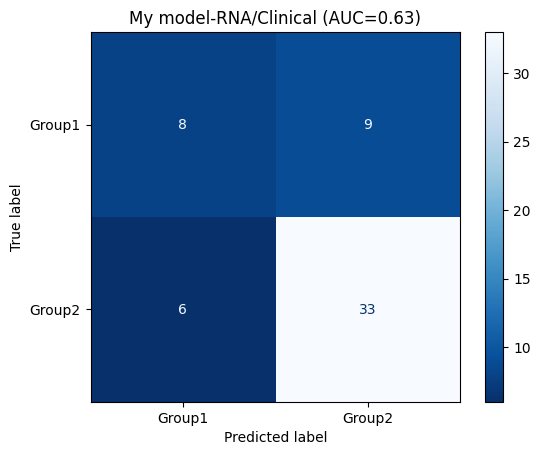

In [149]:
# Show the confusion matrix to check the classifier performance
cm = confusion_matrix(y_test, y_pred_rna)

# Calculate the AUC score and show it on the figure
y_probs = classifier.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_value = roc_auc_score(y_test, y_probs)

# Visualization
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Group1", "Group2"])
disp.plot(cmap='Blues_r', values_format='d')
plt.title(f'My model-RNA/Clinical (AUC={auc_value:.2f})')

plt.savefig("CM_RNA_classifier.png", dpi=100)

In [162]:
# Check if the microarray data normalized or not
print(f"Max: {max([max(validate_data_microarray.iloc[x, :]) for x in range(validate_data_microarray.shape[0])])}")
print(f"Min: {min([min(validate_data_microarray.iloc[x, :]) for x in range(validate_data_microarray.shape[0])])}")

gene_means = validate_data_microarray.mean(axis=0)
gene_stds = validate_data_microarray.std(axis=0)
print(f"Means: {gene_means.mean():.4f}")
print(f"STDs:  {gene_stds.mean():.4f}")

# --> Normalization was done already!


Max: 19.91907
Min: 2.633256
Means: 6.5886
STDs:  0.3341


In [171]:
# Use validation microarray data to run the classifier
# Merge the microarray data and the corresponding clinical data
df_2 = pd.concat([validate_data_microarray, validate_data_clinical], axis=1)

X = df_2.drop("Recurrence", axis=1)
X = X[X_train_final.columns]
y = df_2["Recurrence"]

y_pred_microarray = classifier.predict(X)

<Figure size 600x500 with 0 Axes>

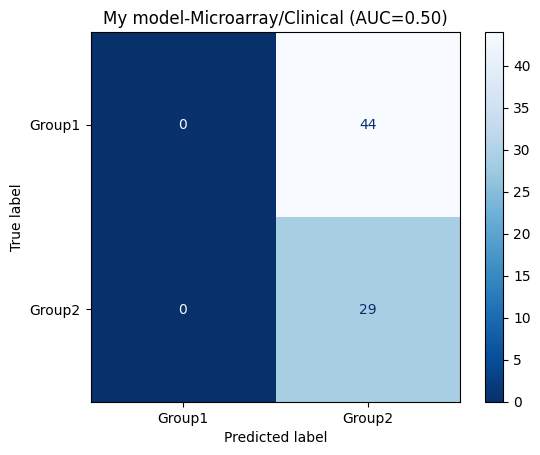

In [172]:
# Show the confusion matrix to check the classifier performance
cm = confusion_matrix(y, y_pred_microarray)

# Calculate the AUC score and show it on the figure
y_probs = classifier.predict_proba(X)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_probs)
auc_value = roc_auc_score(y, y_probs)

# Visualization
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Group1", "Group2"])
disp.plot(cmap='Blues_r', values_format='d')
plt.title(f'My model-Microarray/Clinical (AUC={auc_value:.2f})')

plt.savefig("CM_Microarray_classifier.png", dpi=100)

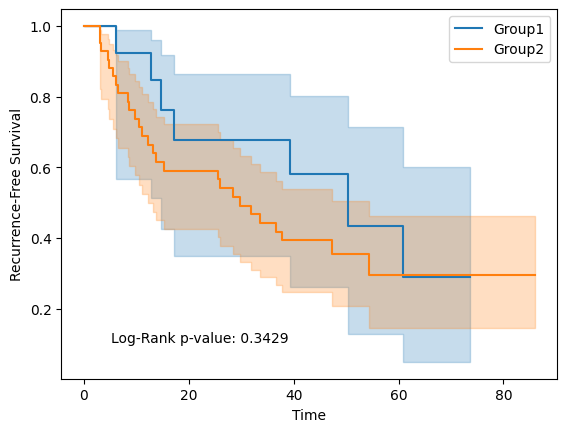

In [195]:
# Plot survival curve to see the group prediction result
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

# Prepare the dataframe with needed infomation
df_prediction = data_clinical.iloc[y_test.index, [3, 4]]
df_prediction["prediction"] = y_pred_rna

df = df_prediction.dropna(subset=["RFS_time"])

group_1 = df[df['prediction'] == 0]
group_2 = df[df['prediction'] == 1]

kmf.fit(group_1['RFS_time'], event_observed=group_1['Recurrence'], label='Group1')
kmf.plot_survival_function(ax=ax)

kmf.fit(group_2['RFS_time'], event_observed=group_2['Recurrence'], label='Group2')
kmf.plot_survival_function(ax=ax)

results = logrank_test(group_1['RFS_time'], group_2['RFS_time'], 
                       event_observed_A=group_1['Recurrence'], 
                       event_observed_B=group_2['Recurrence'])

# 6. Add labels and P-value to the plot
plt.xlabel('Time')
plt.ylabel('Recurrence-Free Survival')
plt.annotate(f'Log-Rank p-value: {results.p_value:.4f}', xy=(0.1, 0.1), xycoords='axes fraction')

plt.savefig("Survival_curve.png", dpi=100)
